In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pandas as pd
from pathlib import Path
from admanifest.manifest import load_manifest_data
from admanifest.analytics import get_flat_projects_and_datasets

rc('font', family='sans-serif', size=16)
rc('axes', grid=True)
rc('figure', figsize=(16, 8))

In [3]:
def load_manifest_and_check_errors():
    here = Path('..').resolve()
    manifest = load_manifest_data(here)
    if manifest.errors:
        for error in manifest.errors:
            print(error, file=sys.stderr)
    return manifest

In [4]:
manifest = load_manifest_and_check_errors()
table = list(get_flat_projects_and_datasets(manifest))
df = pd.DataFrame(table)
df.head()

,dataset,object,owner,project,property,stars,users
0,gov/ivpk/opendata.gov.lt,duomenys/rinkinys,gov/ivpk,projects/atviriduomenys.lt,id,1.0,NaN
1,gov/ivpk/opendata.gov.lt,duomenys/rinkinys,gov/ivpk,projects/atviriduomenys.lt,pavadinimas,1.0,NaN
2,gov/ivpk/opendata.gov.lt,duomenys/rinkinys,gov/ivpk,projects/atviriduomenys.lt,aprašymas,1.0,NaN
3,gov/ivpk/opendata.gov.lt,duomenys/rinkinys,gov/ivpk,projects/atviriduomenys.lt,sukurta,1.0,NaN
4,gov/ivpk/opendata.gov.lt,duomenys/rinkinys,gov/ivpk,projects/atviriduomenys.lt,atnaujinta,0.0,NaN


In [5]:
df.to_csv('manifest.csv')

## Duomenų brandos lygis

Duomenų brandos lygis vertinamas pagal [penkių žvaigždučių skalę](https://5stardata.info/en/).

Atvirų duomenų manifestas naudoja kiek patikslintą ir detalesnę penkių žvaigždučių skalę, kurios aprašymą rastite žemiau.

### 0 žvaigždučių

0 žvaigždučių vertinama tada, kai duomenys iš vis neteikiami arba jų tiesiog nėra. Teoriškai, jei duomenys yra, bet jie neteikiami, tai yra geriau, nei duomenų išvis nėra ir jie nekaupiami. Tikriausiai tokiu atveju, reikėtų tikslesnio vertinimo. Bet kol kas, abu variantai vertinami vienodai.

### 1 žvaigždutė

Duomenys yra pateikti bet kokia forma, tai gali būti laisvas tekstas, paveiksliukas ir pan.

### 2 žvaigždutės

Jei duomenys yra struktūruoti, bet pateikti nestandartiniu arba uždaru duomenų formatu. Jei norint nuskaityti duomenis reikia įsigyti specializuotą nuosavybinę programinę įrangą, tai reiškia, kad duomenų formatas yra uždaras. Jei norint nuskaityti duomenis reikia įdėti papildomų pastangų, tam kad juos nuskaityti, tai reiškia, kad naudojamas nestandartinis duomenų formatas.

Pavyzdžiui skaičiuoklės failai dažniausiai patenka į nestandartinių duomenų formatų kategoriją, kadangi skaičiuoklęs leidžia lenteles formatuoti, apjungti celes ir panašiai, todėl dažnai reikia įdėti papildomų pastangų, tam, kad duomenis teisingai nuskaityti.

XML failai dažnai yra laikomi nestandartiniu duomenų formatu, nebent naudojama atvira ir plačiai naudojama XML schema duomenims aprašyti, pavydžui RDF-XML ar pan. Visa kita yra nestandartiniai formatai.

CSV failas taip pat gali pakliūti į nestandartinių formatų kategoriją, jei nėra galimybės failo nuskaityti automatiškai. Pavyzdžui jei CSV failo antraštės atskira kabliataškais, o visos kitos eilutės kablialais, jei antraštė yra sudaryta iš hierarchinės struktūros, kuri keli stuplpeliai yra sugrūpuoti ir pan.

Visais šiais atvejais duomenų nuskaityti automatiškai galimybės nėra ir eikia įdėti papildomų pastangų norint nuskaityti duomenis.

### 3 žvaigždutės

Jei duomenis galima nuskaityti automatiniu būdu, tada duomenys yra 3 žvaigždučių brandos. Į šia kategorija dažniausiai patenka CSV failai, reliacinės duomenų bazės ir pan.

### 4 žvaigždutės

Jei duomenis ne tik galima nuskaityti automatiškai, bet jie yra [normalizuoti](https://en.wikipedia.org/wiki/Database_normalization) ir kiekvienas objektas turi unikalų identifikatorių (pirminį raktą), tada duomenys yra 4 žvaigždučių brandos.

### 5 žvaigždutės

Jei kiekvienas objektas ir kiekviena objekto savybė turi globalų unikalų identifikatorių arba URI, tada šie duomenys yra aukščiausio penkių žvaigždučių brandos.

Norint gauti globalius unikalius identifikatorius, reikia tiek objektus, tiek jų savybes susieti su žinomais savybių žodynais arba egzistuojančiais objektais kituose duomenų šaltiniuose, tokiuose kaip DBPedia ar pan.

Jei nepavyksta rasti norimo globalaus identifikatoriaus, galima naudoti savo sugalvotą identifikatorių.

## Vidutinis projektams prieinamų duomenų brandos lygis

Vidutinis brandos lygis apskaičiuojamas surandant duomenų tiekėją teikiantį duomenis aukščiausiu brandos lygiu ir paskaičiuojant visų laukų brandos lygio vidurkį.

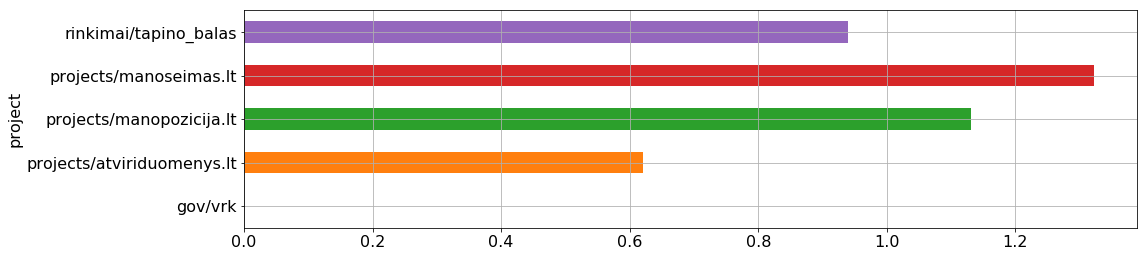

In [6]:
df.groupby('project').stars.mean().plot.barh(figsize=(16, 4));

## Projektai pagal vidutinį naudotojų skaičių per metus

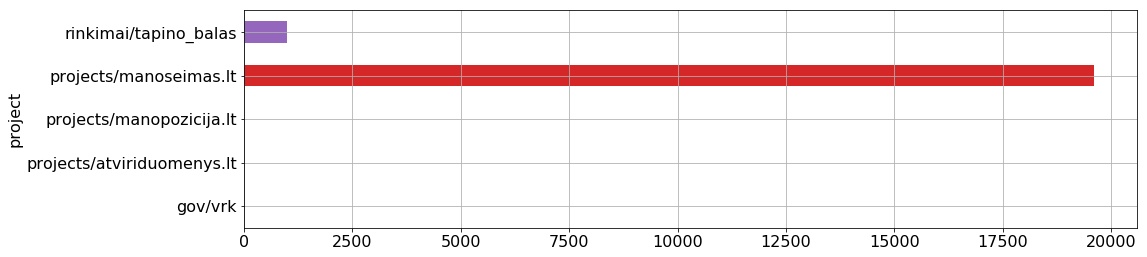

In [7]:
df.groupby('project').users.first().plot.barh(figsize=(16, 4));

## Prioritetinių duomenų rinkinių sąrašas

Prioritetinių duomenų rinkinių sąrašas apskaičiuotas imant duomenų brandos lygio vidurkį visų laukų, kurie reikalingi projektams ir tą duomenų rinkinį naudojančių bendra projekto naudotojų sumą. Galutiniai rezultatai surūšiuoti pagal brandos lygi didėjančia tvarka ir pagal projektų naudotojų skaičių mažėjančia tvarka.

In [8]:
tdf = df.copy()
tdf['project'] = tdf['project'].fillna('')
tdf['users'] = tdf['users'].fillna(0)
tdf = tdf.dropna(subset=['dataset']).groupby(['dataset', 'project']).agg({
    'stars': ['sum', 'count'],
    'users': 'first',
    'project': 'first',
}).groupby(level=0).agg({
    ('stars', 'sum'): 'sum',
    ('stars', 'count'): 'sum',
    ('users', 'first'): 'sum',
    ('project', 'first'): 'count',
})
tdf = pd.DataFrame({
    'stars': tdf[('stars', 'sum')] / tdf[('stars', 'count')],
    'users': tdf[('users', 'first')],
    'projects': tdf[('project', 'first')],
})
tdf['score'] = (
    (tdf['stars'] / 5) * -1 + 1 +
    (tdf['users'] / tdf['users'].max())
) / .02
tdf.sort_values('score', ascending=False)

,stars,users,projects,score
dataset,,,,
gov/lrs/ad,1.318841,19615.285714,3,84.386209
gov/vrk/rinkejopuslapis.lt/kandidatai,1.720000,20615.285714,4,82.800000
gov/rc/jar,0.000000,1000.000000,2,52.425385
gov/savivaldybės/vilnius/taryba,0.285714,8.000000,1,47.162260
gov/ivpk/opendata.gov.lt,0.633333,0.000000,2,43.666667
gov/vrk/vrk.lt/kandiidato_puslapis,0.984375,1000.000000,2,42.581635
gov/vrk/arcgis.com/EP_2014_R_APL,0.843750,0.000000,1,41.562500
gov/vrk/rinkejopuslapis.lt/rezultatai/referendume_gauti_balsai,1.173913,0.000000,1,38.260870
gov/policija/epolicija/eismo_įvykiai,2.000000,0.000000,1,30.000000


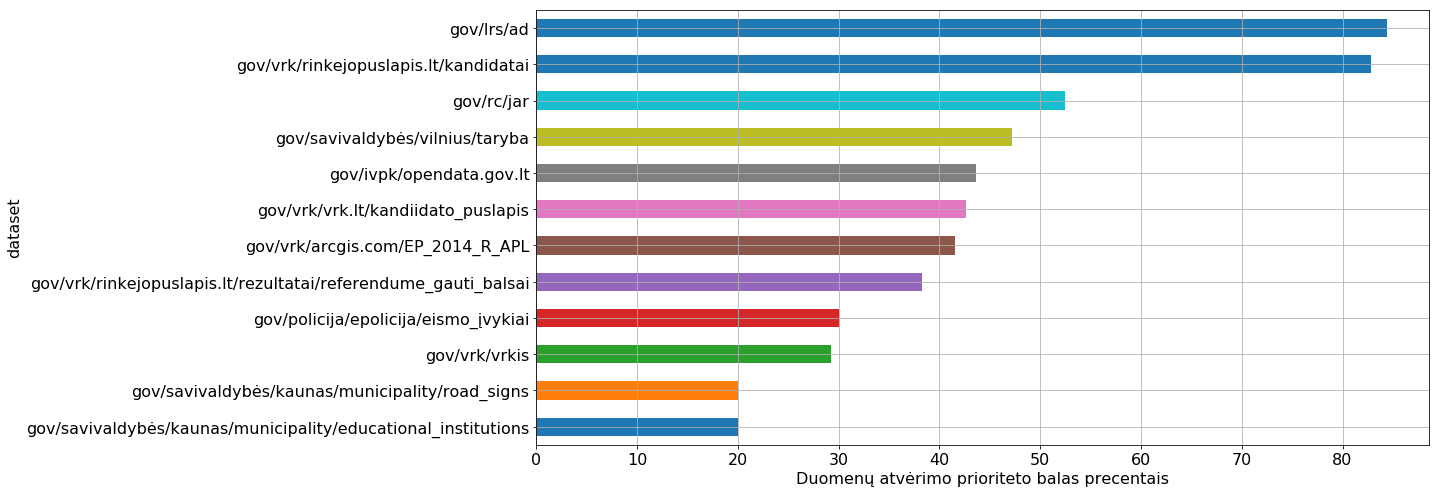

In [9]:
tdf.score.sort_values(ascending=True).plot.barh(figsize=(16, 8))
xlabel("Duomenų atvėrimo prioriteto balas precentais");

## Duomenų rinkiniai pagal brandos lygį

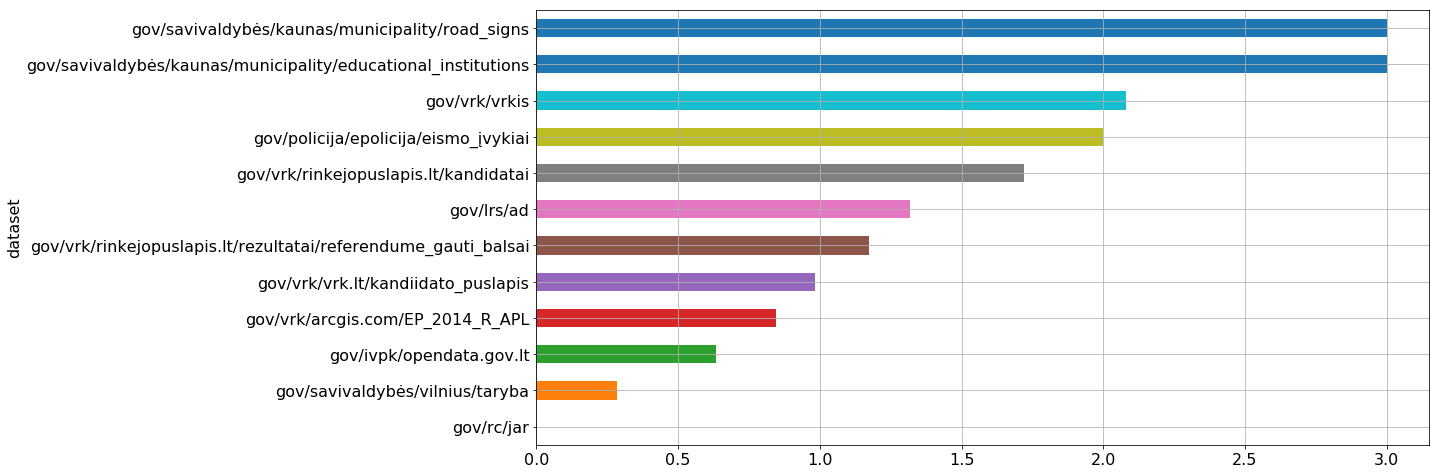

In [10]:
df.dropna(subset=['dataset']).groupby('dataset').stars.mean().sort_values().plot.barh(figsize=(16, 8));

## Duomenų tiekėjai pagal duomenų brandos lygį

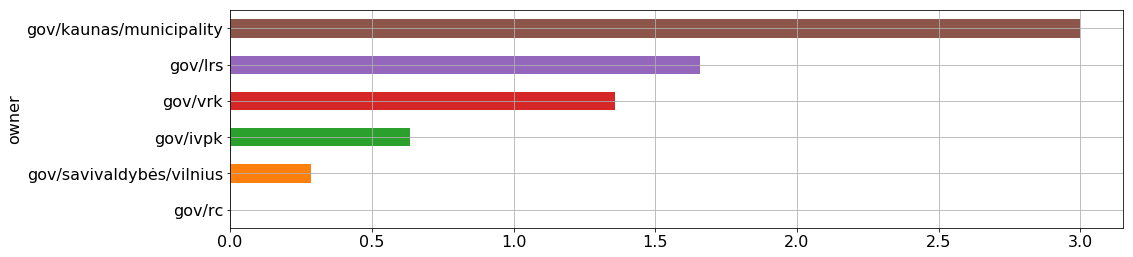

In [11]:
df.dropna(subset=['owner']).groupby('owner').stars.mean().sort_values().plot.barh(figsize=(16, 4));

## Duomenų tiekėjai pagal projektams reikalingų duomenų laukų skaičių

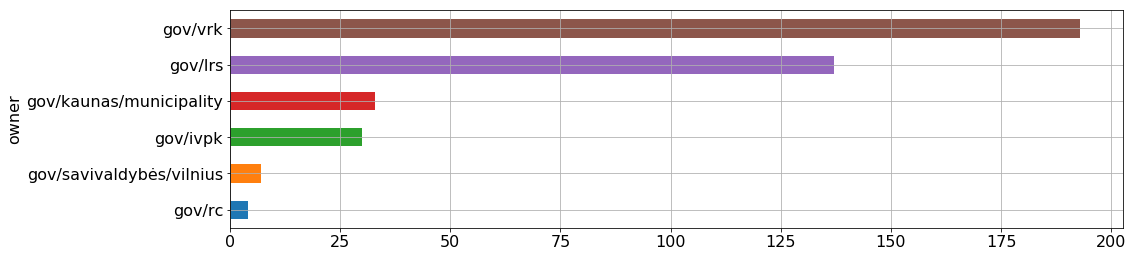

In [12]:
df.dropna(subset=['owner']).groupby('owner').property.count().sort_values().plot.barh(figsize=(16, 4));